### Look at single units for Blanche, correlations with Belief State Value

In [3]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
from scipy import stats
import warnings
from scipy.ndimage import gaussian_filter1d
import seaborn as sns

warnings.filterwarnings('ignore')

### How many units are there per session? 

In [2]:
sessions = pd.read_pickle(BL_SESSIONS_PATH)


In [4]:
SMOOTH = 1
def get_frs(row):
    session = row.session_name
    fr_path = f"/data/patrick_res/firing_rates/BL_{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{SMOOTH}_smooth.pickle"
    frs = pd.read_pickle(fr_path)
    return pd.Series({"session": session, "num units": frs.UnitID.nunique()})


num_units_per_session = sessions.apply(get_frs, axis=1)

In [5]:
num_units_per_session.style.hide()

session,num units
20190123,12
20190124,22
20190125,26
20190128,12
20190312,19
20190313,29
20190329,11


In [6]:
num_units_per_session.sum()

session      141331454
num units          131
dtype: int64

### Look for units correlated with belief state value?

In [46]:
correlations = pd.read_pickle("/data/patrick_res/glm_2/bl_belief_state_value_correlations.pickle")

In [47]:
correlations["r_mag"] = correlations.r_value.abs()
top = correlations.sort_values(by="r_mag", ascending=False)[:5]

In [54]:
top.style.hide()

UnitID,session,PseudoUnitID,slope,intercept,r_value,p_value,std_err,r_mag
7,20190313,2019031307,39.086697,-12.117962,0.358215,0.000012,8.609954,0.358215
2,20190312,2019031202,-9.180030,5.410624,-0.247792,0.000105,2.326526,0.247792
21,20190125,2019012521,30.970487,4.237882,0.245761,0.000000,5.552443,0.245761
6,20190124,2019012406,-14.390578,10.461545,-0.235800,0.000002,2.995498,0.235800
7,20190123,2019012307,-24.097247,40.752761,-0.218880,0.008630,9.046720,0.218880


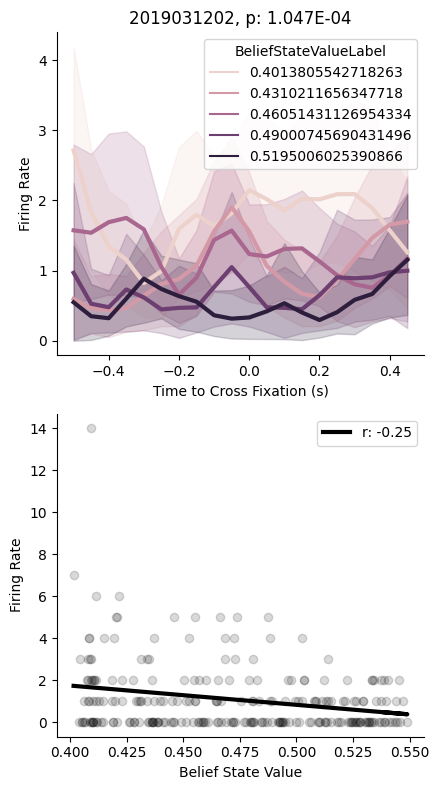

In [52]:
SMOOTH = 1
mode = "FiringRate"
# plt.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(2, 1, figsize=(4.5, 8))

row = top.iloc[1]
session = str(int(row.session))

behavior_path = BL_SESS_BEHAVIOR_PATH.format(sess_name=session)
beh = pd.read_csv(behavior_path)

# filter trials 
beh = behavioral_utils.get_valid_trials_blanche(beh)
beh = behavioral_utils.get_beliefs_per_session(beh, session, subject="BL")
# beh = behavioral_utils.get_prev_choice_fbs(beh)
out, bins = pd.cut(beh["BeliefStateValue"], 5, labels=False, retbins=True)
beh["BeliefStateValueBin"] = out
beh["BeliefStateValueLabel"] = bins[out]

fr_path = f"/data/patrick_res/firing_rates/BL_{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{SMOOTH}_smooth.pickle"

frs = pd.read_pickle(fr_path)
frs = frs[frs.UnitID == row.UnitID]
agg = frs.groupby(["UnitID", "TrialNumber"]).mean().reset_index()

ax = axs[0]
sub_merged = pd.merge(frs, beh, on="TrialNumber")
sub_merged["Time to Cross Fixation"] = sub_merged["TimeBins"] - 0.5
sns.lineplot(sub_merged, x="Time to Cross Fixation", y="FiringRate", hue="BeliefStateValueLabel", linewidth=3, ax=ax)
ax.get_legend()
ax.set_ylabel("Firing Rate")
ax.set_xlabel("Time to Cross Fixation (s)")
# ax.set_xticks([-0.4, 0.0, .4])
# ax.set_xticklabels([-0.4, 0.0, .4])
ax.spines[['right', 'top']].set_visible(False)
ax.set_title(f"{int(row.PseudoUnitID)}, p: {row.p_value:.3E}")


ax = axs[1]
sub_agg_merged = pd.merge(agg, beh, on="TrialNumber")
slope, intercept, r_value, p_value, std_err = stats.linregress(sub_agg_merged["BeliefStateValue"], sub_agg_merged[mode])
ax.scatter(sub_agg_merged["BeliefStateValue"], sub_agg_merged[mode], alpha=0.15, color="black")
ax.plot(sub_agg_merged["BeliefStateValue"], sub_agg_merged["BeliefStateValue"] * slope + intercept, color="black", linewidth=3, label=f"r: {r_value:.2f}")
ax.legend()
# ax.set_xticks([.35, .45, .55])
# ax.set_xticklabels([.35, .45, .55])
ax.set_xlabel("Belief State Value")
ax.set_ylabel(f"Firing Rate")
ax.spines[['right', 'top']].set_visible(False)
fig.tight_layout()